In [1]:
# Nonlinear MPC test using kinematic bicycle model for car
# We want to use the kinematic bicycle model from this paper (Figure 3)
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4

# which has states:
# x, y = positional coordinates in inertial frame
# ψ = angle of car centerline in inertial frame
# ̇ψ = change of angle
# β = angle between car centerline and velocity vector
# ̇β = change of angle

# and has the equations:
# ̇x = v cos(ψ + β)
# ̇y = v sin(ψ + β)
# ̇v = a
# ̇ψ = v / lᵣ sin(β)
# β = arctan(lᵣ/(lf + lᵣ) tan(δf))
# ̇β = v/(lf + lᵣ) tan(δf) - v/lᵣ sin(β)
# ̇δf = ω

# and we want to solve it. Define the model:


The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\\ \beta\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}
where the two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).
The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
\\
\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}
\end{gather*}

## Casadi setup
From http://casadi.sourceforge.net/v3.4.4/users_guide/casadi-users_guide.pdf

In [1]:
import numpy as np
import casadi
from direct_collocation import MpcProblem
from KinematicBicycleCar import KinematicBicycleCar

In [4]:
# Set up a visualization

import matplotlib.pyplot as plt
import matplotlib as mpl



In [5]:
'''# We construct the model as a set of differential-algebraic equations (DAE)
car = casadi.DaeBuilder()
# Parameters
n = 5 # states
m = 2 # controls
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4

a_limit = np.array([-5, 1])
# Steering limit max/min in radians
delta_f_limit = np.array([-np.pi/4, np.pi/4])

# Constants
lr = 2.10 # distance from CG to back wheel in meters
lf = 2.67
# Source, page 40: https://www.diva-portal.org/smash/get/diva2:860675/FULLTEXT01.pdf

# States
z    = car.add_x('z', 5)
x    = z[0]
y    = z[1]
v    = z[2]
psi  = z[3]
beta = z[4]

STATE_NAMES = ['x', 'y', 'v', 'psi', 'beta']
 
# Controls
u       = car.add_u('u',2)       # acceleration
a       = u[0]
delta_f = u[1] # front steering angle
CONTROL_NAMES = ['a', 'delta_f']

# Define ODEs
xdot = v*casadi.cos(psi + beta)
ydot = v*casadi.sin(psi + beta)
vdot = a
psidot = v/lr*casadi.sin(beta)
betadot = v/(lf + lr)*casadi.tan(delta_f) - v/lr*casadi.sin(beta)

zdot = casadi.vertcat(xdot, ydot, vdot, psidot, betadot)
car.add_ode('zdot', zdot)
'''
car = KinematicBicycleCar(N = 30, step = 0.01)

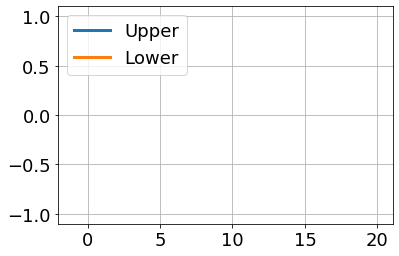

In [6]:
# Acceleration bounds from 
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Sec3

# TODO: Fix lower/upper bounds to sample from functions for x, y.
def lowerbounds(varname, i, k):
    if varname == 'z':
        limits = [-1.0,
                  -1.0,
                  0.0,
                  -np.pi/4,
                  -np.pi/4]
        return limits[i]
    elif varname == 'u':
        limits = [-1.70, -np.pi/4]
        return limits[i]
    else:
        print("HUGE ERROR: lowerbounds doesn't understand variable named "+varname)
        return -np.inf
    
def upperbounds(varname, i, k):
    if varname == 'z':
        limits = [20.0,
                  1.0,
                  20.0,
                  np.pi/4,
                  np.pi/4]
        return limits[i]
    elif varname == 'u':
        limits = [0.84, np.pi/4]
        return limits[i]
    else:
        print("HUGE ERROR: upperbounds doesn't understand variable named "+varname)
        return np.inf

    
upper_bound = np.empty((250,2))
lower_bound = np.empty((250,2))
for k in range(250):
    upper_bound[k,0] = upperbounds('z',0,k)
    upper_bound[k,1] = upperbounds('z',1,k)
    
    lower_bound[k,0] = lowerbounds('z',0,k)
    lower_bound[k,1] = lowerbounds('z',1,k)
    
plt.plot(upper_bound[:,0], upper_bound[:,1], label="Upper")
plt.plot(lower_bound[:,0], lower_bound[:,1], label="Lower")
plt.legend()

In [23]:

        
ic = [0.0, 0.0, 5.5, np.pi/8, 0.0]
car.set_initial(ic)

# Cost
cost = (car.dae.x[0][2]-5)**2

In [28]:
    
mpcprob = MpcProblem(car.dae,         # casadi.DaeBuilder()
                     cost,        # casadi symbolic objective
                     lowerbounds, # given name of state/control variable, return lower bound
                     upperbounds, # given name of state/control variable, return upper bound
                     N    = 30,   # MPC horizon (steps)
                     step = 0.05, # Time step (seconds)
                     )
uk = [0.0,0.0]

n_runs = 20
x_plan = np.empty((mpcprob.n,n_runs+1))
u_plan = np.empty((mpcprob.m,n_runs))
x_true = np.empty((mpcprob.n,n_runs+1))
x_true[:,0] = ic
x_plan[:,0] = ic

for k in range(n_runs):
    xk_opt, uk_opt = mpcprob.run(x_true[:,k])
    for i in range(5):
        x_plan[i,k+1] = xk_opt[i][1]
    for i in range(2):
        u_plan[i,k] = uk_opt[i][1]
    x_true[:,k+1] = mpcprob.simulate(x_true[:,k], u_plan[:,k])
    
    # hack, test changing cost
    if k == n_runs//2:
        mpcprob.set_cost(car.dae.x[0][2]**2)

for k in range(1,n_runs):
    print("True:", x_true[:,k])
    print("Pred:", x_plan[:,k])
    print("Error:", np.linalg.norm(x_true[:,k]-x_plan[:,k],2))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  27  1.4016041e-02 6.37e-11 1.22e-07  -8.6 5.23e-03  -4.6 1.00e+00 1.00e+00h  1
  28  1.4016040e-02 3.44e-09 4.58e-08  -8.6 2.20e-03  -4.7 1.00e+00 1.00e+00h  1
  29  1.4016040e-02 3.93e-10 8.39e-09  -8.6 1.21e-03  -5.2 1.00e+00 1.00e+00h  1

Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............:   1.4016040143714653e-02    1.4016040143714653e-02
Dual infeasibility......:   8.3912207893506234e-09    8.3912207893506234e-09
Constraint violation....:   3.9266826595829585e-10    3.9266826595829585e-10
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   8.3912207893506234e-09    8.3912207893506234e-09


Number of objective function evaluations             = 30
Number of objective gradient evaluations             = 30
Number of equality constraint evaluations            = 30
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobia

  67  7.0481273e-03 2.48e-14 8.10e-07  -8.6 1.69e-05  -1.3 1.00e+00 1.00e+00h  1
  68  7.0481273e-03 1.75e-14 8.07e-07  -8.6 6.31e-06  -0.9 1.00e+00 1.00e+00h  1
  69  7.0481272e-03 1.64e-14 8.01e-07  -8.6 1.88e-05  -1.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  7.0481272e-03 1.27e-14 7.99e-07  -8.6 7.03e-06  -0.9 1.00e+00 1.00e+00h  1
  71  7.0481272e-03 1.62e-14 7.92e-07  -8.6 2.09e-05  -1.4 1.00e+00 1.00e+00h  1

Number of Iterations....: 71

                                   (scaled)                 (unscaled)
Objective...............:   7.0481272095095108e-03    7.0481272095095108e-03
Dual infeasibility......:   7.9189164579200065e-07    7.9189164579200065e-07
Constraint violation....:   1.6209256159527285e-14    1.6209256159527285e-14
Complementarity.........:   2.5059035596801073e-09    2.5059035596801073e-09
Overall NLP error.......:   7.9189164579200065e-07    7.9189164579200065e-07


Number of objective funct

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

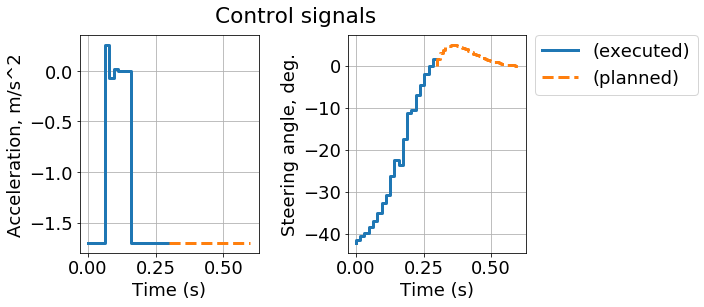

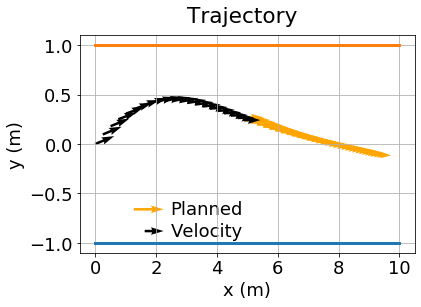

In [29]:
u_plt, u_ax1, u_ax2 = car.plot_u(u_plan, mpcprob.u_opt)
# control limits
x_plt, x_ax = car.plot_x(x_plan, mpcprob.x_opt)
x_ax.plot([0.0,10.0], [-1,-1]) # Road boundary (lower)
x_ax.plot([0.0,10.0], [1,1]) # (upper)
plt.show()